In [1]:
import pandas as pd
import glob
import numpy as np
import warnings
import random
from random import getrandbits
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from datetime import datetime

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
warnings.filterwarnings("ignore")

# Set max_columns to None
pd.set_option('display.max_columns', None)

In [3]:
# Define the path to CSV files
files_path = "match_data/atp_matches_*.csv"

# Use glob to get a list of all matching file paths
files = glob.glob(files_path)

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each file, read it into a DataFrame, and append it to the list
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
    
    
# Concatenate all DataFrames in the list along the rows
tennis_data = pd.concat(dfs, ignore_index=True)

In [4]:
file_path = "atp_matches_2024 (with betting).csv"

# Read the CSV file into a DataFrame
df24 = pd.read_csv(file_path)

# Create a DataFrame without 'B365W' and 'B365L'
df_24 = df24.drop(['B365W', 'B365L'], axis=1)

In [5]:
# Create a DataFrame with only the necessary columns
betting_lines_24 = df24[['tourney_date', 'winner_id', 'winner_name', 'loser_name', 'loser_id', 'B365W', 'B365L']]

# Extract year, month, and day from 'tourney_date'
betting_lines_24['tourney_year'] = betting_lines_24['tourney_date'].astype(str).str[:4].astype(int)
betting_lines_24['tourney_month'] = betting_lines_24['tourney_date'].astype(str).str[4:6].astype(int)
betting_lines_24['tourney_day'] = betting_lines_24['tourney_date'].astype(str).str[6:].astype(int)

# Drop the original 'tourney_date' column
betting_lines_24 = betting_lines_24.drop('tourney_date', axis=1)

In [6]:
# Add the df_24 dataframe data to the tennis_data dataframe
tennis_data = pd.concat([tennis_data, df_24], axis=0, ignore_index=True)

In [7]:
tennis_data.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2.0,NaN,Kei Nishikori,R,178.0,JPN,29.0,106421,4.0,NaN,Daniil Medvedev,R,198.0,RUS,22.8,6-4 3-6 6-2,3,F,124.0,3.0,3.0,77.0,44.0,31.0,17.0,13.0,3.0,6.0,8.0,6.0,100.0,54.0,34.0,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4.0,NaN,Daniil Medvedev,R,198.0,RUS,22.8,104542,NaN,PR,Jo-Wilfried Tsonga,R,188.0,FRA,33.7,7-6(6) 6-2,3,SF,82.0,10.0,1.0,52.0,33.0,28.0,14.0,10.0,0.0,1.0,17.0,2.0,77.0,52.0,36.0,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2.0,NaN,Kei Nishikori,R,178.0,JPN,29.0,104871,NaN,NaN,Jeremy Chardy,R,188.0,FRA,31.8,6-2 6-2,3,SF,66.0,2.0,2.0,47.0,33.0,26.0,9.0,8.0,2.0,2.0,10.0,3.0,46.0,27.0,15.0,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NaN,PR,Jo-Wilfried Tsonga,R,188.0,FRA,33.7,200282,7.0,NaN,Alex De Minaur,R,183.0,AUS,19.8,6-4 7-6(2),3,QF,106.0,12.0,2.0,68.0,43.0,34.0,15.0,11.0,4.0,5.0,1.0,2.0,81.0,60.0,38.0,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4.0,NaN,Daniil Medvedev,R,198.0,RUS,22.8,105683,5.0,NaN,Milos Raonic,R,196.0,CAN,28.0,6-7(2) 6-3 6-4,3,QF,129.0,12.0,3.0,105.0,68.0,48.0,25.0,16.0,8.0,8.0,29.0,5.0,94.0,56.0,46.0,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0


In [8]:
tennis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39792 entries, 0 to 39791
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          39792 non-null  object 
 1   tourney_name        39792 non-null  object 
 2   surface             39739 non-null  object 
 3   draw_size           39792 non-null  int64  
 4   tourney_level       39792 non-null  object 
 5   tourney_date        39792 non-null  int64  
 6   match_num           39792 non-null  int64  
 7   winner_id           39792 non-null  int64  
 8   winner_seed         17010 non-null  float64
 9   winner_entry        5236 non-null   object 
 10  winner_name         39792 non-null  object 
 11  winner_hand         39783 non-null  object 
 12  winner_ht           39015 non-null  float64
 13  winner_ioc          39792 non-null  object 
 14  winner_age          39786 non-null  float64
 15  loser_id            39792 non-null  int64  
 16  lose

# Data cleaning

#### Delete rows where match wasn't finished

In [9]:
# List of values indicating matches that were stopped before completion
stop_match_values = ['W/O', 'RET', 'Def.', 'DEF', 'Played', 'Default', 'Walkover', 'ABD']

# Filter out rows where 'score' column contains any of the stop_match_values
tennis_data = tennis_data[~tennis_data['score'].isin(stop_match_values)]

# Reset the index after filtering
tennis_data.reset_index(drop=True, inplace=True)

#### Date to datetime & ordering dataframe by date (past to present)

In [10]:
# Convert 'tourney_date' to datetime
tennis_data['tourney_date'] = pd.to_datetime(tennis_data['tourney_date'], format='%Y%m%d')

In [11]:
# Sort the DataFrame by 'tourney_date' and 'match_num' in ascending order
tennis_data.sort_values(['tourney_date', 'match_num'], inplace=True)

# Reset the index after sorting
tennis_data.reset_index(drop=True, inplace=True)

#### Keep useful columns

In [12]:
# Define the columns to keep
selected_columns = ['tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num',
                    'winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht',
                    'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name',
                    'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
                    'minutes', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points']

# Keep only the selected columns in the DataFrame
tennis_data = tennis_data[selected_columns]

#### Process Null values

In [13]:
# Switch NaN values of these columnns (0 means no seed)
tennis_data['winner_entry'].fillna("Rank. Entry", inplace=True)
tennis_data['loser_entry'].fillna("Rank. Entry", inplace=True)
tennis_data['winner_seed'].fillna("0", inplace=True)
tennis_data['loser_seed'].fillna("0", inplace=True)

In [14]:
# Drop rows where 'surface' is null
tennis_data = tennis_data.dropna(subset=['surface'])

# Drop rows where 'winner_rank' or 'loser_rank' is null
tennis_data = tennis_data.dropna(subset=['winner_rank', 'loser_rank'])

# Reset the index after dropping rows
tennis_data.reset_index(drop=True, inplace=True)

Most players in the tour are right handed, so for the aprox. 100 lines that are missing, the value we will imputate it with an 'R'


In [15]:
# Impute 'R' in 'winner_hand' where it is null
tennis_data['winner_hand'].fillna('R', inplace=True)

# Impute 'R' in 'loser_hand' where it is null
tennis_data['loser_hand'].fillna('R', inplace=True)

In [16]:
# Calculate the average values for 'winner_ht', 'loser_ht' and 'minutes'
average_winner_ht = tennis_data['winner_ht'].mean()
average_loser_ht = tennis_data['loser_ht'].mean()
average_minutes = tennis_data['minutes'].mean()
average_winner_age = tennis_data['winner_age'].mean()

tennis_data['loser_age'] = pd.to_numeric(tennis_data['loser_age'], errors='coerce')
average_loser_age = tennis_data['loser_age'].mean()

# Impute the missing values with the average values
tennis_data['winner_ht'].fillna(average_winner_ht, inplace=True)
tennis_data['loser_ht'].fillna(average_loser_ht, inplace=True)
tennis_data['minutes'].fillna(average_minutes, inplace=True)
tennis_data['winner_age'].fillna(average_winner_age, inplace=True)
tennis_data['loser_age'].fillna(average_loser_age, inplace=True)

In [17]:
tennis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38795 entries, 0 to 38794
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_name        38795 non-null  object        
 1   surface             38795 non-null  object        
 2   draw_size           38795 non-null  int64         
 3   tourney_level       38795 non-null  object        
 4   tourney_date        38795 non-null  datetime64[ns]
 5   match_num           38795 non-null  int64         
 6   winner_id           38795 non-null  int64         
 7   winner_seed         38795 non-null  object        
 8   winner_entry        38795 non-null  object        
 9   winner_name         38795 non-null  object        
 10  winner_hand         38795 non-null  object        
 11  winner_ht           38795 non-null  float64       
 12  winner_ioc          38795 non-null  object        
 13  winner_age          38795 non-null  float64   

# Feature Extraction

In [18]:
# Let's create a copy to avoid modifying the original DataFrame
tennis_data_processed = tennis_data.copy()

# Drop the 'winner_name' and 'loser_name' columns
tennis_data_processed.drop(['winner_name', 'loser_name', 'minutes', 'match_num', 'score'], axis=1, inplace=True)

#### Categorical variables to numeric codes & one-hot encoding

In [19]:
# Convert selected string variables to numeric codes
categorical_to_code = ['tourney_name', 'tourney_level', 'winner_seed', 'loser_seed', 'winner_entry', 'loser_entry', 'winner_ioc', 'loser_ioc',  'winner_hand', 'loser_hand', 'round']

for column in categorical_to_code:
    tennis_data_processed[column] = tennis_data_processed[column].astype('category').cat.codes

In [20]:
# One-hot encode the 'surface' column
tennis_data_processed = pd.get_dummies(tennis_data_processed, columns=['surface'])

# Convert the resulting columns to integers
tennis_data_processed[['surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard']] = tennis_data_processed[['surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard']].astype(int)

#### Rename columns to player1 and player2 & reorder

In [21]:
# Rename the columns
tennis_data_processed = tennis_data_processed.rename(columns=lambda col: col.replace('winner_', 'player1_') if 'winner_' in col else col)
tennis_data_processed = tennis_data_processed.rename(columns=lambda col: col.replace('loser_', 'player2_') if 'loser_' in col else col)

# Specify the desired column order
desired_order = [
    'tourney_name', 'draw_size', 'tourney_level', 'tourney_date',
    'best_of', 'round', 'surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard',
    'player1_id', 'player1_seed', 'player1_entry', 'player1_hand', 'player1_ht',
    'player1_ioc', 'player1_age', 'player1_rank', 'player1_rank_points',
    'player2_id', 'player2_seed', 'player2_entry', 'player2_hand', 'player2_ht',
    'player2_ioc', 'player2_age', 'player2_rank', 'player2_rank_points'
]

# Reorder the columns
tennis_data_processed = tennis_data_processed[desired_order]

#### Creating target variable: 1 = player1 won ; 0 = player1 lost

In [22]:
# Add 'target' column with random boolean values
tennis_data_processed['target'] = pd.Series([bool(getrandbits(1)) for _ in range(len(tennis_data_processed))])

# Perform the random switch using boolean masks
columns_to_switch = ['player1_id', 'player1_seed', 'player1_entry', 'player1_hand', 'player1_ht', 'player1_ioc', 'player1_age', 'player1_rank', 'player1_rank_points',
                      'player2_id', 'player2_seed', 'player2_entry', 'player2_hand', 'player2_ht', 'player2_ioc', 'player2_age', 'player2_rank', 'player2_rank_points']

for col in columns_to_switch:
    tennis_data_processed[col], tennis_data_processed[col.replace('player1_', 'player2_')] = (
        tennis_data_processed[col] * tennis_data_processed['target'] + tennis_data_processed[col.replace('player1_', 'player2_')] * ~tennis_data_processed['target'],
        tennis_data_processed[col.replace('player1_', 'player2_')] * tennis_data_processed['target'] + tennis_data_processed[col] * ~tennis_data_processed['target']
    )


#### Switch bool values to int

In [23]:
# Switching values in the 'target' column
tennis_data_processed['target'] = tennis_data_processed['target'].astype(int)

In [24]:
tennis_data_processed.head(5)

,tourney_name,draw_size,tourney_level,tourney_date,best_of,round,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,player1_id,player1_seed,player1_entry,player1_hand,player1_ht,player1_ioc,player1_age,player1_rank,player1_rank_points,player2_id,player2_seed,player2_entry,player2_hand,player2_ht,player2_ioc,player2_age,player2_rank,player2_rank_points,target
0,22,32,0,2010-01-03,3,5,0,0,0,1,104053,0,5,1,188.0,84,27.3,7.0,4410.0,103429,33,5,1,183.0,3,30.3,77.0,598.0,1
1,22,32,0,2010-01-03,3,5,0,0,0,1,104958,33,7,0,198.0,3,22.5,134.0,400.0,104999,33,5,0,190.0,32,22.3,78.0,590.0,1
2,22,32,0,2010-01-03,3,5,0,0,0,1,104755,33,5,1,185.0,27,23.5,52.0,850.0,103813,33,5,0,185.0,28,28.4,88.0,568.0,1
3,22,32,0,2010-01-03,3,5,0,0,0,1,103781,5,5,0,183.0,4,28.6,28.0,1260.0,105051,33,4,1,188.0,3,22.1,285.0,151.0,0
4,22,32,0,2010-01-03,3,5,0,0,0,1,104607,3,5,1,196.0,18,24.2,20.0,1655.0,105194,33,4,1,183.0,3,21.4,251.0,179.0,1


#### Visualize number of wins and losses for player1 

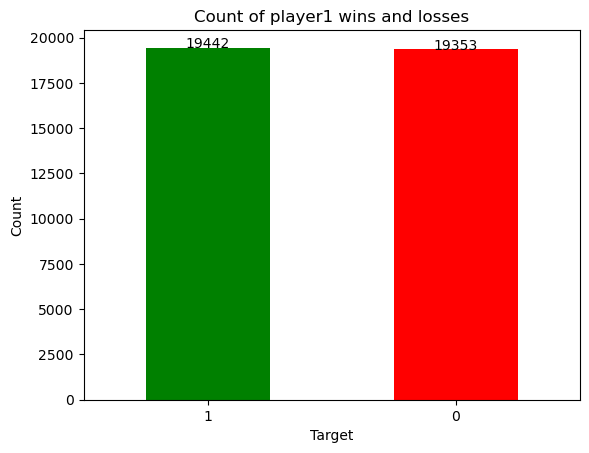

In [25]:
# Count the number of 1 and 0 values in the 'target' column
count_values = tennis_data_processed['target'].value_counts()

# Plotting the bar graph
ax = count_values.plot(kind='bar', color=['green', 'red'])
plt.title('Count of player1 wins and losses')
plt.xlabel('Target')
plt.ylabel('Count')

# Annotating each bar with its count
for i, count in enumerate(count_values):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.xticks(rotation=0)
plt.show()

#### Create Head-to-head columns, based on the results of the previous matches

In [26]:
def get_h2h(df):
    cond = df['target'].eq(1)
    players = pd.concat([df['player1_id'], df['player2_id']])
    unique_players = players.unique()
    tmp = pd.Series(np.where(cond, df['player1_id'], df['player2_id']), index=df.index)
    
    # Check if both players are in unique_players
    if unique_players.size == 2:
        cond2 = df['player1_id'].eq(unique_players[0])
        df['player1_h2h'] = np.where(cond2, tmp.eq(unique_players[0]).shift().fillna(0).cumsum(), tmp.eq(unique_players[1]).shift().fillna(0).cumsum())
        df['player2_h2h'] = np.where(cond2, tmp.eq(unique_players[1]).shift().fillna(0).cumsum(), tmp.eq(unique_players[0]).shift().fillna(0).cumsum())
    else:
        # Handle the case when there's only one unique player
        df['player1_h2h'] = 0
        df['player2_h2h'] = 0
    
    return df

# Create MultiIndex from sorted player IDs
grp = pd.MultiIndex.from_arrays(np.sort(tennis_data_processed[['player1_id', 'player2_id']]).T)

# Apply the function to calculate head-to-head
tennis_data_processed = tennis_data_processed.groupby(grp, group_keys=False).apply(get_h2h)

# Convert 'player1_h2h' and 'player2_h2h' columns to integers
tennis_data_processed['player1_h2h'] = tennis_data_processed['player1_h2h'].astype(int)
tennis_data_processed['player2_h2h'] = tennis_data_processed['player2_h2h'].astype(int)

Check an example of the h2h for players: 104745 - Rafael Nadal & 106401 - Nick Kyrgios

In [27]:
player1_id = 104745
player2_id = 106401

# Create a boolean mask based on the conditions
mask = ((tennis_data_processed['player1_id'] == player1_id) & (tennis_data_processed['player2_id'] == player2_id)) | ((tennis_data_processed['player1_id'] == player2_id) & (tennis_data_processed['player2_id'] == player1_id))

# Apply the mask to get the subset of rows
subset_rows = tennis_data_processed[mask]

subset_rows

,tourney_name,draw_size,tourney_level,tourney_date,best_of,round,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,player1_id,player1_seed,player1_entry,player1_hand,player1_ht,player1_ioc,player1_age,player1_rank,player1_rank_points,player2_id,player2_seed,player2_entry,player2_hand,player2_ht,player2_ioc,player2_age,player2_rank,player2_rank_points,target,player1_h2h,player2_h2h
13407,980,128,3,2014-06-23,5,4,0,0,1,0,106401,33,7,1,193.0,3,19.1,144.0,400.0,104745,1,5,0,185.0,26,28.0,1.0,12500.0,1,0,0
18596,951,64,4,2016-05-09,3,4,0,1,0,0,104745,4,5,0,185.0,24,29.9,5.0,5675.0,106401,33,5,1,193.0,3,21.0,20.0,1795.0,1,0,1
21462,920,64,4,2017-05-08,3,4,0,1,0,0,104745,3,5,0,185.0,24,30.9,5.0,4375.0,106401,15,5,1,193.0,3,22.0,20.0,2155.0,1,1,1
22378,31,64,4,2017-08-14,3,2,0,0,0,1,104745,0,5,0,185.0,26,31.1,2.0,7555.0,106401,33,5,1,193.0,3,22.2,23.0,1770.0,0,2,1
22776,17,32,0,2017-10-02,3,1,0,0,0,1,106401,7,5,1,193.0,3,22.4,19.0,2245.0,104745,0,5,0,185.0,24,31.3,1.0,9465.0,0,2,2
26512,1,32,0,2019-02-25,3,4,0,0,0,1,106401,33,5,1,193.0,3,23.8,72.0,750.0,104745,0,5,0,185.0,26,32.7,2.0,8320.0,1,2,3
27509,980,128,3,2019-07-01,5,6,0,0,1,0,104745,2,5,0,185.0,24,33.0,2.0,7945.0,106401,33,5,1,193.0,3,24.1,43.0,1045.0,1,3,3
28917,11,128,3,2020-01-20,5,4,0,0,0,1,106401,22,5,1,193.0,3,24.7,26.0,1520.0,104745,0,5,0,185.0,24,33.6,1.0,10235.0,0,3,4
33535,910,128,4,2022-03-07,3,2,0,0,0,1,106401,33,8,1,193.0,3,26.8,132.0,493.0,104745,3,5,0,185.0,24,35.7,4.0,6515.0,0,3,5


#### Calculate the record (wins and losses) each player has on the surface the match is beeing played. Wins and losses from before the match.

In [28]:
def calculate_surface_stats(row, df, surface_cols):
    current_surface = [col for col in surface_cols if row[col] == 1]
    current_surface = current_surface[0].split('_')[-1]

    player1_id = row['player1_id']
    player2_id = row['player2_id']

    # Filter matches before the current one and on the same surface
    matches_player1 = df[
        (df.index < row.name) & 
        (df[f'surface_{current_surface}'] == 1) & 
        ((df['player1_id'] == player1_id) | (df['player2_id'] == player1_id))
    ]
    matches_player2 = df[
        (df.index < row.name) & 
        (df[f'surface_{current_surface}'] == 1) & 
        ((df['player1_id'] == player2_id) | (df['player2_id'] == player2_id))
    ]

    # Count wins and losses for player1
    if not matches_player1.empty:
        player1_W_surface = matches_player1[((matches_player1['player1_id'] == player1_id) & (matches_player1['target'] == 1)) | ((matches_player1['player2_id'] == player1_id) & (matches_player1['target'] == 0))].shape[0]
        player1_L_surface = matches_player1[((matches_player1['player2_id'] == player1_id) & (matches_player1['target'] == 1)) | ((matches_player1['player1_id'] == player1_id) & (matches_player1['target'] == 0))].shape[0]
    else:
        player1_W_surface = 0
        player1_L_surface = 0

    # Count wins and losses for player2
    if not matches_player2.empty:
        player2_W_surface = matches_player2[((matches_player2['player1_id'] == player2_id) & (matches_player2['target'] == 1)) | ((matches_player2['player2_id'] == player2_id) & (matches_player2['target'] == 0))].shape[0]
        player2_L_surface = matches_player2[((matches_player2['player2_id'] == player2_id) & (matches_player2['target'] == 1)) | ((matches_player2['player1_id'] == player2_id) & (matches_player2['target'] == 0))].shape[0]
    else:
        player2_W_surface = 0
        player2_L_surface = 0

    return pd.Series({
        'player1_W_surface': player1_W_surface,
        'player1_L_surface': player1_L_surface,
        'player2_W_surface': player2_W_surface,
        'player2_L_surface': player2_L_surface
    })

In [29]:
# Apply the function to calculate surface stats
surface_cols = ['surface_Carpet', 'surface_Clay', 'surface_Grass', 'surface_Hard']

tennis_data_processed[['player1_W_surface', 'player1_L_surface', 'player2_W_surface', 'player2_L_surface']] = tennis_data_processed.apply(
    lambda row: calculate_surface_stats(row, tennis_data_processed, surface_cols),
    axis=1
)

Check an example of W & L for the surface the matches are played in, for a specific player: 209950 - Arthur Fils

In [30]:
tennis_data_processed[(tennis_data_processed['player1_id'] == 209950) 
                      | (tennis_data_processed['player2_id'] == 209950)]

,tourney_name,draw_size,tourney_level,tourney_date,best_of,round,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,player1_id,player1_seed,player1_entry,player1_hand,player1_ht,player1_ioc,player1_age,player1_rank,player1_rank_points,player2_id,player2_seed,player2_entry,player2_hand,player2_ht,player2_ioc,player2_age,player2_rank,player2_rank_points,target,player1_h2h,player2_h2h,player1_W_surface,player1_L_surface,player2_W_surface,player2_L_surface
35536,942,64,4,2022-10-31,3,6,0,0,0,1,209950,33,4,1,185.000000,29,18.300000,308.0,164.0,104926,33,2,1,178.000000,41,35.4,59.0,792.0,0,0,0,0,0,145,155
35946,930,32,0,2023-02-06,3,5,0,0,0,1,104755,33,5,1,185.000000,29,36.600000,45.0,910.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,256,160,0,1
35978,930,32,0,2023-02-06,3,4,0,0,0,1,105138,3,5,1,183.000000,26,34.800000,24.0,1740.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,247,148,1,1
35999,930,32,0,2023-02-06,3,2,0,0,0,1,111460,33,5,1,191.000000,29,26.200000,70.0,756.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,11,26,2,1
36008,930,32,0,2023-02-06,3,8,0,0,0,1,206173,1,5,1,188.000000,41,21.400000,17.0,2195.0,209950,33,8,1,185.000000,29,18.6,163.0,361.0,1,0,0,93,39,3,1
36103,924,32,0,2023-02-20,3,5,0,0,0,1,209950,33,7,1,185.000000,27,18.600000,118.0,449.0,126128,33,5,1,185.000000,74,25.5,97.0,549.0,1,0,0,3,2,11,13
36164,924,32,0,2023-02-20,3,2,0,0,0,1,209950,33,7,1,185.000000,27,18.600000,118.0,449.0,104527,33,5,1,183.000000,80,37.9,105.0,512.0,1,0,0,4,2,256,130
36176,924,32,0,2023-02-20,3,8,0,0,0,1,126127,33,5,1,185.000000,27,26.600000,60.0,794.0,209950,33,8,1,185.000000,29,18.6,118.0,449.0,1,0,0,23,29,5,2
36813,951,128,4,2023-05-08,3,3,0,1,0,0,209950,33,4,1,185.000000,27,18.900000,119.0,520.0,207678,33,4,0,183.000000,2,21.4,105.0,575.0,1,0,0,0,0,9,8
36845,951,128,4,2023-05-08,3,6,0,1,0,0,209950,33,4,1,185.000000,29,18.900000,119.0,520.0,208029,6,5,1,185.000000,19,20.0,7.0,3865.0,0,0,0,1,0,26,20


#### Calculate the record (wins and losses) each player has on the tournament the match is beeing played. Wins and losses from before the match.

In [31]:
def calculate_tourney_stats(row, df):
    player1_id = row['player1_id']
    player2_id = row['player2_id']
    tourney_name = row['tourney_name']

    # Filter matches before the current one and in the same tournament
    matches_player1 = df[
        (df.index < row.name) & 
        (df['tourney_name'] == tourney_name) & 
        ((df['player1_id'] == player1_id) | (df['player2_id'] == player1_id))
    ]
    matches_player2 = df[
        (df.index < row.name) & 
        (df['tourney_name'] == tourney_name) & 
        ((df['player1_id'] == player2_id) | (df['player2_id'] == player2_id))
    ]

    # Count wins and losses for player1
    if not matches_player1.empty:
        player1_W_tourney = matches_player1[((matches_player1['player1_id'] == player1_id) & (matches_player1['target'] == 1)) | ((matches_player1['player2_id'] == player1_id) & (matches_player1['target'] == 0))].shape[0]
        player1_L_tourney = matches_player1[((matches_player1['player2_id'] == player1_id) & (matches_player1['target'] == 1)) | ((matches_player1['player1_id'] == player1_id) & (matches_player1['target'] == 0))].shape[0]
    else:
        player1_W_tourney = 0
        player1_L_tourney = 0

    # Count wins and losses for player2
    if not matches_player2.empty:
        player2_W_tourney = matches_player2[((matches_player2['player1_id'] == player2_id) & (matches_player2['target'] == 1)) | ((matches_player2['player2_id'] == player2_id) & (matches_player2['target'] == 0))].shape[0]
        player2_L_tourney = matches_player2[((matches_player2['player2_id'] == player2_id) & (matches_player2['target'] == 1)) | ((matches_player2['player1_id'] == player2_id) & (matches_player2['target'] == 0))].shape[0]
    else:
        player2_W_tourney = 0
        player2_L_tourney = 0

    return pd.Series({
        'player1_W_tourney': player1_W_tourney,
        'player1_L_tourney': player1_L_tourney,
        'player2_W_tourney': player2_W_tourney,
        'player2_L_tourney': player2_L_tourney
    })

In [32]:
# Apply the function to calculate tourney stats
tennis_data_processed[['player1_W_tourney', 'player1_L_tourney', 'player2_W_tourney', 'player2_L_tourney']] = tennis_data_processed.apply(
    lambda row: calculate_tourney_stats(row, tennis_data_processed),
    axis=1
)

Check an example of W & L for the surface the matches are played for a specific player and tournament: 207989 - Carlos Alcaraz & 979 - Wimbledon

In [33]:
# Create a dictionary to map tournament names to codes
tourney_name_mapping = dict(zip(tennis_data['tourney_name'], tennis_data_processed['tourney_name']))

In [34]:
tennis_data_processed[((tennis_data_processed['player1_id'] == 207989)&(tennis_data_processed['tourney_name'] == 980)) 
                      | ((tennis_data_processed['player2_id'] == 207989)&(tennis_data_processed['tourney_name'] == 980))]

,tourney_name,draw_size,tourney_level,tourney_date,best_of,round,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,player1_id,player1_seed,player1_entry,player1_hand,player1_ht,player1_ioc,player1_age,player1_rank,player1_rank_points,player2_id,player2_seed,player2_entry,player2_hand,player2_ht,player2_ioc,player2_age,player2_rank,player2_rank_points,target,player1_h2h,player2_h2h,player1_W_surface,player1_L_surface,player2_W_surface,player2_L_surface,player1_W_tourney,player1_L_tourney,player2_W_tourney,player2_L_tourney
31548,980,128,3,2021-06-28,5,3,0,0,1,0,207989,33,7,1,185.0,24,18.1,75.0,924.0,106034,33,2,1,183.0,46,28.8,116.0,697.0,1,0,0,0,0,0,1,0,0,0,1
31580,980,128,3,2021-06-28,5,6,0,0,1,0,207989,33,8,1,185.0,26,18.1,75.0,924.0,106421,1,5,1,198.0,70,25.3,2.0,10280.0,0,0,0,1,0,23,13,1,0,6,3
34347,980,128,3,2022-06-27,5,3,0,0,1,0,105526,33,5,1,193.0,32,32.1,155.0,363.0,207989,4,5,1,185.0,24,19.1,7.0,4890.0,0,1,0,14,25,1,1,5,8,1,1
34403,980,128,3,2022-06-27,5,6,0,0,1,0,134868,33,5,1,188.0,61,25.9,53.0,984.0,207989,4,5,1,185.0,24,19.1,7.0,4890.0,0,0,0,5,5,2,1,1,1,2,1
34430,980,128,3,2022-06-27,5,5,0,0,1,0,106214,31,5,1,196.0,32,28.9,36.0,1155.0,207989,4,5,1,185.0,24,19.1,7.0,4890.0,0,0,0,8,3,3,1,3,1,3,1
34444,980,128,3,2022-06-27,5,4,0,0,1,0,207989,4,5,1,185.0,26,19.1,7.0,4890.0,206173,9,5,1,188.0,41,20.8,13.0,3185.0,0,1,0,4,1,3,4,4,1,3,1
37230,980,128,3,2023-07-03,5,3,0,0,1,0,104871,33,5,1,188.0,29,36.3,542.0,65.0,207989,0,5,1,185.0,24,20.1,1.0,7675.0,0,0,0,26,29,9,2,11,11,4,2
37294,980,128,3,2023-07-03,5,6,0,0,1,0,207989,0,5,1,185.0,24,20.1,1.0,7675.0,124186,33,5,1,183.0,29,26.4,84.0,711.0,1,0,0,10,2,1,0,5,2,1,0
37326,980,128,3,2023-07-03,5,5,0,0,1,0,111797,24,5,1,198.0,14,27.7,28.0,1336.0,207989,0,5,1,185.0,24,20.1,1.0,7675.0,0,0,1,8,8,11,2,3,3,6,2
37342,980,128,3,2023-07-03,5,4,0,0,1,0,126610,33,5,1,196.0,43,27.2,38.0,1082.0,207989,0,5,1,185.0,24,20.1,1.0,7675.0,0,1,2,36,7,12,2,13,3,7,2


#### Calculate each player wins and losses in the last 10 matches

In [35]:
def calculate_last_10_stats(row, df):
    player1_id = row['player1_id']
    player2_id = row['player2_id']

    # Filter matches before the current one
    matches_player1 = df[
        (df.index < row.name) & 
        ((df['player1_id'] == player1_id) | (df['player2_id'] == player1_id))
    ]
    matches_player2 = df[
        (df.index < row.name) & 
        ((df['player1_id'] == player2_id) | (df['player2_id'] == player2_id))
    ]

    # Calculate last 10 stats for player1
    player1_W_last10, player1_L_last10 = calculate_last_10(matches_player1, player1_id)

    # Calculate last 10 stats for player2
    player2_W_last10, player2_L_last10 = calculate_last_10(matches_player2, player2_id)

    return pd.Series({
        'player1_W_last10': player1_W_last10,
        'player1_L_last10': player1_L_last10,
        'player2_W_last10': player2_W_last10,
        'player2_L_last10': player2_L_last10
    })

def calculate_last_10(matches, player_id):
    last_10_matches = matches.tail(10)  # Get the last 10 matches

    # Count wins and losses for the last 10 matches
    player_W_last10 = last_10_matches[((last_10_matches['player1_id'] == player_id) & (last_10_matches['target'] == 1)) | ((last_10_matches['player2_id'] == player_id) & (last_10_matches['target'] == 0))].shape[0]
    player_L_last10 = last_10_matches[((last_10_matches['player2_id'] == player_id) & (last_10_matches['target'] == 1)) | ((last_10_matches['player1_id'] == player_id) & (last_10_matches['target'] == 0))].shape[0]

    return player_W_last10, player_L_last10


# Calculate last 10 stats for each match
last_10_stats_columns = tennis_data_processed.apply(lambda row: calculate_last_10_stats(row, tennis_data_processed), axis=1)

# Add last 10 stats columns to the original DataFrame
tennis_data_processed[['player1_W_last10', 'player1_L_last10', 'player2_W_last10', 'player2_L_last10']] = last_10_stats_columns[['player1_W_last10', 'player1_L_last10', 'player2_W_last10', 'player2_L_last10']]


In [36]:
tennis_data_processed[(tennis_data_processed['player1_id'] == 209950) 
                      | (tennis_data_processed['player2_id'] == 209950)]

,tourney_name,draw_size,tourney_level,tourney_date,best_of,round,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,player1_id,player1_seed,player1_entry,player1_hand,player1_ht,player1_ioc,player1_age,player1_rank,player1_rank_points,player2_id,player2_seed,player2_entry,player2_hand,player2_ht,player2_ioc,player2_age,player2_rank,player2_rank_points,target,player1_h2h,player2_h2h,player1_W_surface,player1_L_surface,player2_W_surface,player2_L_surface,player1_W_tourney,player1_L_tourney,player2_W_tourney,player2_L_tourney,player1_W_last10,player1_L_last10,player2_W_last10,player2_L_last10
35536,942,64,4,2022-10-31,3,6,0,0,0,1,209950,33,4,1,185.000000,29,18.300000,308.0,164.0,104926,33,2,1,178.000000,41,35.4,59.0,792.0,0,0,0,0,0,145,155,0,0,1,9,0,0,4,6
35946,930,32,0,2023-02-06,3,5,0,0,0,1,104755,33,5,1,185.000000,29,36.600000,45.0,910.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,256,160,0,1,28,7,0,0,6,4,0,1
35978,930,32,0,2023-02-06,3,4,0,0,0,1,105138,3,5,1,183.000000,26,34.800000,24.0,1740.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,247,148,1,1,4,3,1,0,7,3,1,1
35999,930,32,0,2023-02-06,3,2,0,0,0,1,111460,33,5,1,191.000000,29,26.200000,70.0,756.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,11,26,2,1,2,2,2,0,5,5,2,1
36008,930,32,0,2023-02-06,3,8,0,0,0,1,206173,1,5,1,188.000000,41,21.400000,17.0,2195.0,209950,33,8,1,185.000000,29,18.6,163.0,361.0,1,0,0,93,39,3,1,1,2,3,0,6,4,3,1
36103,924,32,0,2023-02-20,3,5,0,0,0,1,209950,33,7,1,185.000000,27,18.600000,118.0,449.0,126128,33,5,1,185.000000,74,25.5,97.0,549.0,1,0,0,3,2,11,13,0,0,3,1,3,2,5,5
36164,924,32,0,2023-02-20,3,2,0,0,0,1,209950,33,7,1,185.000000,27,18.600000,118.0,449.0,104527,33,5,1,183.000000,80,37.9,105.0,512.0,1,0,0,4,2,256,130,1,0,4,3,4,2,6,4
36176,924,32,0,2023-02-20,3,8,0,0,0,1,126127,33,5,1,185.000000,27,26.600000,60.0,794.0,209950,33,8,1,185.000000,29,18.6,118.0,449.0,1,0,0,23,29,5,2,6,2,2,0,5,5,5,2
36813,951,128,4,2023-05-08,3,3,0,1,0,0,209950,33,4,1,185.000000,27,18.900000,119.0,520.0,207678,33,4,0,183.000000,2,21.4,105.0,575.0,1,0,0,0,0,9,8,0,0,0,0,5,3,5,5
36845,951,128,4,2023-05-08,3,6,0,1,0,0,209950,33,4,1,185.000000,29,18.900000,119.0,520.0,208029,6,5,1,185.000000,19,20.0,7.0,3865.0,0,0,0,1,0,26,20,1,0,0,0,6,3,8,2


#### Calculate the number of weeks a player has been inactive

In [37]:
# Define a modified function to calculate weeks since last match
def calculate_weeks_since_last_match(row, df):
    player1_id = row['player1_id']
    player2_id = row['player2_id']
    tourney_date = row['tourney_date']

    # Filter matches before the current one and in the same tournament for player1
    matches_player1 = df[
        (df.index < row.name) & 
        ((df['player1_id'] == player1_id) | (df['player2_id'] == player1_id))
    ]

    # Filter matches before the current one and in the same tournament for player2
    matches_player2 = df[
        (df.index < row.name) & 
        ((df['player1_id'] == player2_id) | (df['player2_id'] == player2_id))
    ]

    # Calculate weeks since last match for player1
    player1_weeks_since_last_match = calculate_weeks_since_last_match_inner(matches_player1, tourney_date)

    # Calculate weeks since last match for player2
    player2_weeks_since_last_match = calculate_weeks_since_last_match_inner(matches_player2, tourney_date)

    return pd.Series({
        'player1_weeks_since_last_match': player1_weeks_since_last_match,
        'player2_weeks_since_last_match': player2_weeks_since_last_match
    })

# Define a function to calculate weeks since last match for a specific player
def calculate_weeks_since_last_match_inner(matches, tourney_date):
    if not matches.empty:
        last_match_date = matches['tourney_date'].max()

        # Calculate weeks since last match
        days_since_last_match = (tourney_date - last_match_date).days
        weeks_since_last_match = (days_since_last_match + 6) // 7  # Ensure at least 1 week if there's any difference
    else:
        # If there are no previous matches, use -1
        weeks_since_last_match = -1

    return weeks_since_last_match

# Convert 'tourney_date' to datetime
tennis_data_processed['tourney_date'] = pd.to_datetime(tennis_data_processed['tourney_date'])

# Calculate weeks since last match for each match
weeks_since_last_match_columns = tennis_data_processed.apply(lambda row: calculate_weeks_since_last_match(row, tennis_data_processed), axis=1)

# Add weeks since last match columns to the original DataFrame
tennis_data_processed[['player1_weeks_inactive', 'player2_weeks_inactive']] = weeks_since_last_match_columns[['player1_weeks_since_last_match', 'player2_weeks_since_last_match']]


In [38]:
tennis_data_processed[(tennis_data_processed['player1_id'] == 209950) 
                      | (tennis_data_processed['player2_id'] == 209950)]

,tourney_name,draw_size,tourney_level,tourney_date,best_of,round,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,player1_id,player1_seed,player1_entry,player1_hand,player1_ht,player1_ioc,player1_age,player1_rank,player1_rank_points,player2_id,player2_seed,player2_entry,player2_hand,player2_ht,player2_ioc,player2_age,player2_rank,player2_rank_points,target,player1_h2h,player2_h2h,player1_W_surface,player1_L_surface,player2_W_surface,player2_L_surface,player1_W_tourney,player1_L_tourney,player2_W_tourney,player2_L_tourney,player1_W_last10,player1_L_last10,player2_W_last10,player2_L_last10,player1_weeks_inactive,player2_weeks_inactive
35536,942,64,4,2022-10-31,3,6,0,0,0,1,209950,33,4,1,185.000000,29,18.300000,308.0,164.0,104926,33,2,1,178.000000,41,35.4,59.0,792.0,0,0,0,0,0,145,155,0,0,1,9,0,0,4,6,-1,2
35946,930,32,0,2023-02-06,3,5,0,0,0,1,104755,33,5,1,185.000000,29,36.600000,45.0,910.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,256,160,0,1,28,7,0,0,6,4,0,1,3,14
35978,930,32,0,2023-02-06,3,4,0,0,0,1,105138,3,5,1,183.000000,26,34.800000,24.0,1740.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,247,148,1,1,4,3,1,0,7,3,1,1,3,0
35999,930,32,0,2023-02-06,3,2,0,0,0,1,111460,33,5,1,191.000000,29,26.200000,70.0,756.0,209950,33,7,1,185.000000,27,18.6,163.0,361.0,0,0,0,11,26,2,1,2,2,2,0,5,5,2,1,0,0
36008,930,32,0,2023-02-06,3,8,0,0,0,1,206173,1,5,1,188.000000,41,21.400000,17.0,2195.0,209950,33,8,1,185.000000,29,18.6,163.0,361.0,1,0,0,93,39,3,1,1,2,3,0,6,4,3,1,0,0
36103,924,32,0,2023-02-20,3,5,0,0,0,1,209950,33,7,1,185.000000,27,18.600000,118.0,449.0,126128,33,5,1,185.000000,74,25.5,97.0,549.0,1,0,0,3,2,11,13,0,0,3,1,3,2,5,5,2,5
36164,924,32,0,2023-02-20,3,2,0,0,0,1,209950,33,7,1,185.000000,27,18.600000,118.0,449.0,104527,33,5,1,183.000000,80,37.9,105.0,512.0,1,0,0,4,2,256,130,1,0,4,3,4,2,6,4,0,0
36176,924,32,0,2023-02-20,3,8,0,0,0,1,126127,33,5,1,185.000000,27,26.600000,60.0,794.0,209950,33,8,1,185.000000,29,18.6,118.0,449.0,1,0,0,23,29,5,2,6,2,2,0,5,5,5,2,0,0
36813,951,128,4,2023-05-08,3,3,0,1,0,0,209950,33,4,1,185.000000,27,18.900000,119.0,520.0,207678,33,4,0,183.000000,2,21.4,105.0,575.0,1,0,0,0,0,9,8,0,0,0,0,5,3,5,5,11,5
36845,951,128,4,2023-05-08,3,6,0,1,0,0,209950,33,4,1,185.000000,29,18.900000,119.0,520.0,208029,6,5,1,185.000000,19,20.0,7.0,3865.0,0,0,0,1,0,26,20,1,0,0,0,6,3,8,2,0,2


#### Drop tourney_date column and switch for year, month and date

In [39]:
# Assuming 'tourney_date' is your datetime feature
tennis_data_processed['tourney_year'] = tennis_data_processed['tourney_date'].dt.year
tennis_data_processed['tourney_month'] = tennis_data_processed['tourney_date'].dt.month
tennis_data_processed['tourney_day'] = tennis_data_processed['tourney_date'].dt.day

# Drop the 'tourney_date' column
tennis_data_processed = tennis_data_processed.drop('tourney_date', axis=1)

In [40]:
# Move 'target' column to the last position
tennis_data_processed = tennis_data_processed[[col for col in tennis_data_processed.columns if col != 'target'] + ['target']]

### Correlation between variables and 'target'

In [41]:
correlation_matrix = tennis_data_processed.corr()
correlation_with_target = correlation_matrix['target'].abs().sort_values(ascending=False)
correlation_with_target

target                    1.000000
player2_seed              0.215031
player2_rank_points       0.208571
player1_rank_points       0.207038
player1_seed              0.202886
player2_W_last10          0.182975
player1_W_last10          0.171164
player2_rank              0.146263
player2_W_surface         0.140738
player1_W_surface         0.136838
player1_rank              0.133322
player1_W_tourney         0.113047
player2_W_tourney         0.112606
player2_L_last10          0.093535
player2_h2h               0.093277
player1_L_last10          0.090958
player1_h2h               0.080242
player2_ht                0.060727
player2_L_surface         0.058475
player1_L_surface         0.054401
player2_ioc               0.054231
player1_ht                0.047709
player1_weeks_inactive    0.044653
player2_L_tourney         0.044485
player1_ioc               0.044244
player1_L_tourney         0.043355
player2_weeks_inactive    0.041093
player1_entry             0.032088
player2_entry       

# Model training and Model comparison

In [42]:
X = tennis_data_processed.drop('target', axis=1)
y = tennis_data_processed['target']

# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression()
}

# Define time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5) 

# Define scoring metric
scoring_metric = make_scorer(accuracy_score)

# Model selection and evaluation
results = {}
for model_name, model in models.items():
    # Perform cross-validation
    cv_results = cross_val_score(model, X, y, cv=tscv, scoring=scoring_metric)
    
    # Store the results
    results[model_name] = cv_results

# Convert the results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display the mean and standard deviation of the cross-validation scores for each model
print("Mean Accuracy:")
print(results_df.mean())

Mean Accuracy:
Random Forest          0.775313
Gradient Boosting      0.894107
Logistic Regression    0.656860
dtype: float64


### Gradient Boosting with training data up to 2022 and test on 2023 data

Accuracy: 0.8829
Precision: 0.8872
Recall: 0.8786
F1 Score: 0.8829


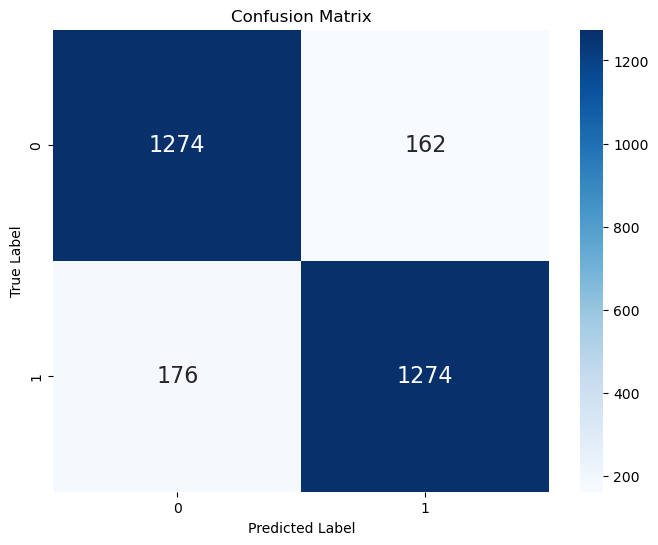

In [43]:
# Split the data into 2023 or not (excluding 2024)
X_train = X[(X['tourney_year'] != 2023) & (X['tourney_year'] != 2024)]
X_test = X[(X['tourney_year'] == 2023) & (X['tourney_year'] != 2024)]
y_train = y[(X['tourney_year'] != 2023) & (X['tourney_year'] != 2024)]
y_test = y[(X['tourney_year'] == 2023) & (X['tourney_year'] != 2024)]

# Train the Gradient Boosting model
model = GradientBoostingClassifier() 
model.fit(X_train, y_train)

# Make predictions and get probabilities
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Create confusion matrix
cm = confusion_matrix(y_test, predictions)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Hyperparameter search

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.9328
Precision: 0.9361
Recall: 0.9297
F1 Score: 0.9329


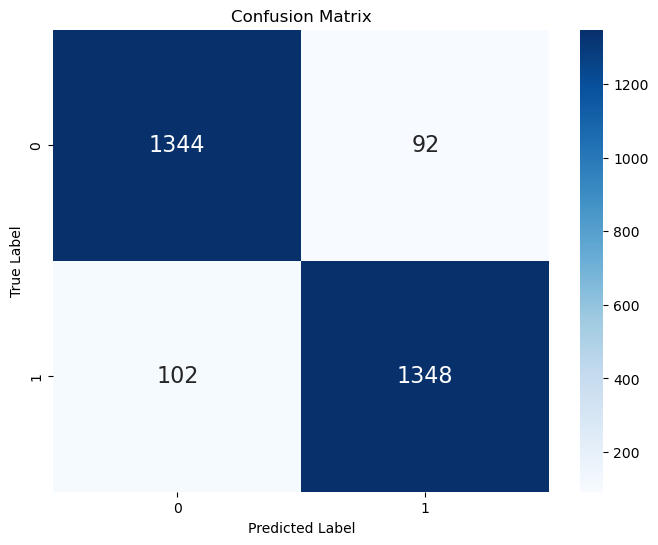

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.6, 0.8],
}

# Initialize the GradientBoostingClassifier
base_model = GradientBoostingClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    base_model, param_grid=param_grid, cv=3, scoring='accuracy'
)

# Fit the model on your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
probabilities = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Create confusion matrix
cm = confusion_matrix(y_test, predictions)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Visualize which surface the model works better on

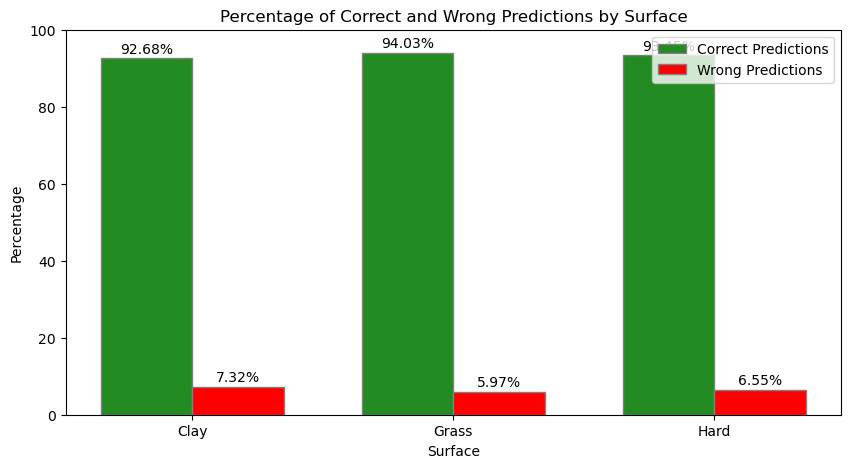

In [45]:
# Add the predicted labels and probabilities to the test set
X_test['Predicted_Label'] = predictions
X_test['Probability'] = probabilities

# Create a new column 'Actual_Surface' based on the columns surface_Clay, surface_Hard, surface_Grass, and surface_Carpet
X_test['Actual_Surface'] = X_test[['surface_Clay', 'surface_Hard', 'surface_Grass', 'surface_Carpet']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# Filter data for correct and wrong predictions
correct_predictions = X_test[X_test['Predicted_Label'] == y_test]
wrong_predictions = X_test[X_test['Predicted_Label'] != y_test]

# Calculate the percentage of correct and wrong predictions by surface
correct_percentage_by_surface = correct_predictions.groupby('Actual_Surface').size() / X_test.groupby('Actual_Surface').size() * 100
wrong_percentage_by_surface = wrong_predictions.groupby('Actual_Surface').size() / X_test.groupby('Actual_Surface').size() * 100

# Create a bar graph
plt.figure(figsize=(10, 5))
barWidth = 0.35
r1 = range(len(correct_percentage_by_surface))
r2 = [x + barWidth for x in r1]

plt.bar(r1, correct_percentage_by_surface, color='forestgreen', width=barWidth, edgecolor='grey', label='Correct Predictions')
plt.bar(r2, wrong_percentage_by_surface, color='red', width=barWidth, edgecolor='grey', label='Wrong Predictions')

plt.xlabel('Surface')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.xticks([r + barWidth / 2 for r in range(len(correct_percentage_by_surface))], correct_percentage_by_surface.index)
plt.title('Percentage of Correct and Wrong Predictions by Surface')

# Add labels on each bar
for i in range(len(correct_percentage_by_surface)):
    plt.text(i, correct_percentage_by_surface[i] + 0.5, f'{correct_percentage_by_surface[i]:.2f}%', ha='center', va='bottom', color='black')

for i in range(len(wrong_percentage_by_surface)):
    plt.text(i + barWidth, wrong_percentage_by_surface[i] + 0.5, f'{wrong_percentage_by_surface[i]:.2f}%', ha='center', va='bottom', color='black')

plt.legend()
plt.show()

### Gradient Boosting with training data up to 2023 and test on 2024 data (Using best Hyperparameters)

Accuracy: 0.9525
Precision: 0.9444
Recall: 0.9577
F1 Score: 0.9510


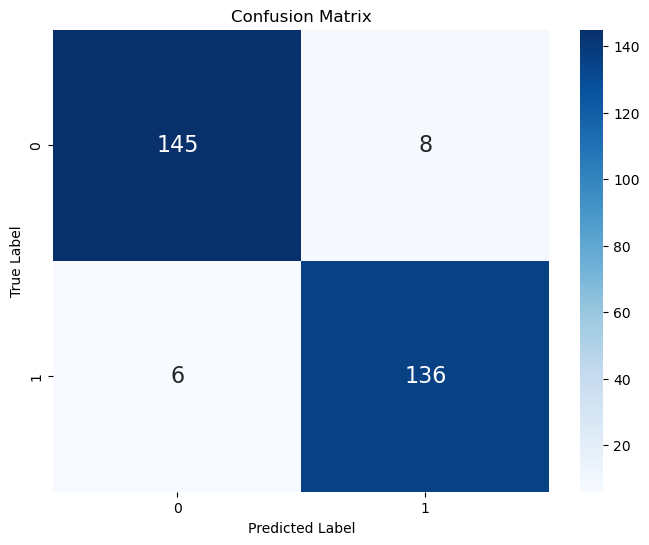

In [46]:
# Split the data into 2024 or not
X_train = X[X['tourney_year'] != 2024]
X_test = X[X['tourney_year'] == 2024]
y_train = y[X['tourney_year'] != 2024]
y_test = y[X['tourney_year'] == 2024]

# Train the Gradient Boosting model
model  = GradientBoostingClassifier(
    learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6)  # Adjust hyperparameters

model.fit(X_train, y_train)

# Make predictions and get probabilities
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Create confusion matrix
cm = confusion_matrix(y_test, predictions)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Analyze the predicted outcomes with the match betting odds

In [47]:
# Add predictions and probabilities to the test data
X_test['predicted_outcome'] = predictions
X_test['predicted_probability'] = probabilities

# Display matches with real and predicted outcomes, and probabilities
result_df = X_test[['tourney_name', 'tourney_year', 'tourney_month', 'tourney_day', 'player1_id', 'player2_id', 'predicted_outcome', 'predicted_probability']]
result_df['actual_outcome'] = y_test.values

#### Merge the dataframe with the predictions with the one with the betting odds

In [48]:
col1 = ['player1_id', 'player1_name', 'player2_name', 'player2_id', 'B365W', 'B365L', 'tourney_year', 'tourney_month', 'tourney_day']
col2 = ['player2_id', 'player2_name', 'player1_name', 'player1_id', 'B365L', 'B365W', 'tourney_year', 'tourney_month', 'tourney_day']
tmp = pd.concat([betting_lines_24.set_axis(col1, axis=1), betting_lines_24.set_axis(col2, axis=1)])
col3 = ['tourney_name', 'tourney_year', 'tourney_month', 'tourney_day', 'player1_id', 'player1_name', 
        'player2_name', 'player2_id', 'B365W', 'B365L', 'predicted_probability', 'predicted_outcome',
        'actual_outcome']
bet_df = result_df.merge(tmp, how='left')[col3]

In [49]:
bet_df

,tourney_name,tourney_year,tourney_month,tourney_day,player1_id,player1_name,player2_name,player2_id,B365W,B365L,predicted_probability,predicted_outcome,actual_outcome
0,3,2024,1,1,126128,Safiullin R.,Shelton B.,210097,2.30,1.62,0.988731,1,1
1,908,2024,1,1,111513,Djere,Shang,209992,1.62,2.30,0.062768,0,0
2,3,2024,1,1,126845,Purcell M.,Rune H.,208029,4.00,1.25,0.178270,0,0
3,908,2024,1,1,132686,Nuno Borges,Kotov,200303,1.80,2.00,0.195365,0,0
4,3,2024,1,1,105777,Dimitrov G.,Andy Murray,104918,1.33,3.40,0.729124,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,924,2024,2,7,105138,Bautista Agut,Khachanov,111575,2.75,1.44,0.872478,1,1
291,34,2024,2,7,105948,Federico Coria,Ramos-Vinolas,105077,1.67,2.20,0.139699,0,0
292,34,2024,2,7,105487,Facundo Bagnis,Roberto Carballes Baena,106148,2.30,1.62,0.811905,1,1
293,34,2024,2,7,202103,Cerundolo F.,Jaume Munar,144719,1.80,2.00,0.918311,1,1


#### Visualize wrong predictions

In [50]:
# Filter the DataFrame to show only rows where predicted outcome is different from actual outcome
mismatched_predictions_df = bet_df[bet_df['predicted_outcome'] != bet_df['actual_outcome']]

# Display the resulting DataFrame
mismatched_predictions_df

,tourney_name,tourney_year,tourney_month,tourney_day,player1_id,player1_name,player2_name,player2_id,B365W,B365L,predicted_probability,predicted_outcome,actual_outcome
12,3,2024,1,2,127760,Lukas Klein,Baez S.,202104,2.00,1.80,0.388912,0,1
18,3,2024,1,2,144869,Etcheverry T.,Machac T.,207830,3.20,1.36,0.587029,1,0
24,3,2024,1,2,208014,Rinky Hijikata,Kokkinakis T.,106423,2.63,1.50,0.426381,0,1
57,10,2024,1,7,126846,Vukic,Daniel,101207,2.10,1.73,0.513850,1,0
61,10,2024,1,8,127339,Gojo,Tabilo,126214,1.50,2.63,0.530965,1,0
72,3,2024,1,9,205734,Seyboth Wild,Bolt,106109,2.10,1.73,0.588975,1,0
100,10,2024,1,11,126214,Tabilo,Norrie,111815,3.40,1.33,0.338841,0,1
118,11,2024,1,14,106331,O Connell C.,Garin C.,106426,1.44,2.75,0.479217,0,1
141,11,2024,1,15,126214,Tabilo,Kovacevic,109655,1.67,2.20,0.664693,1,0
167,11,2024,1,16,122330,Bublik,Nagal,111576,1.17,5.00,0.529304,1,0


#### Analyze how the model works for favourites and underdogs

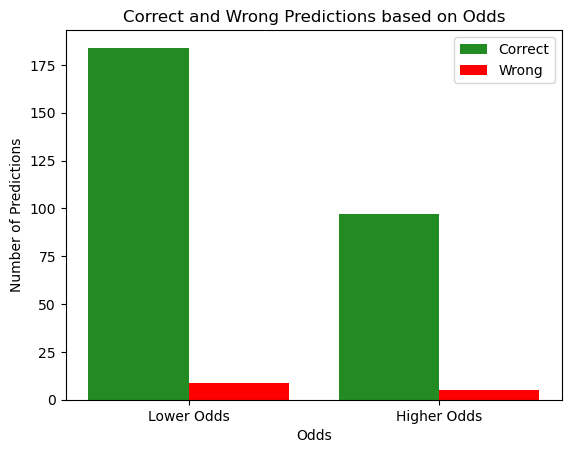

In [51]:
lower_odds_correct = 0
lower_odds_wrong = 0
higher_odds_correct = 0
higher_odds_wrong = 0

for index, row in bet_df.iterrows():
    if row['predicted_outcome'] == row['actual_outcome']:
        if row['predicted_outcome'] == 1:
            if row['B365W'] < row['B365L']:
                lower_odds_correct += 1
            else:
                higher_odds_correct += 1
        else:
            if row['B365W'] <= row['B365L']:
                higher_odds_correct += 1
            else:
                lower_odds_correct += 1
    else:
        if row['predicted_outcome'] == 1:
            if row['B365W'] < row['B365L']:
                lower_odds_wrong += 1
            else:
                higher_odds_wrong += 1
        else:
            if row['B365W'] <= row['B365L']:
                higher_odds_wrong += 1
            else:
                lower_odds_wrong += 1


odds_name = ['Lower Odds', 'Higher Odds']
correct_counts = [lower_odds_correct, higher_odds_correct]
wrong_counts = [lower_odds_wrong, higher_odds_wrong]

X_axis = np.arange(len(odds_name))

plt.bar(X_axis - 0.2, correct_counts, 0.4, color='forestgreen', label='Correct')
plt.bar(X_axis + 0.2, wrong_counts, 0.4, color='red', label='Wrong')

plt.xticks(X_axis, odds_name)
plt.xlabel("Odds")
plt.ylabel("Number of Predictions")
plt.title("Correct and Wrong Predictions based on Odds")
plt.legend()
plt.show()

#### Analyze how the model works when predicting the non-favourite will win (when the odds are more than 2.5)

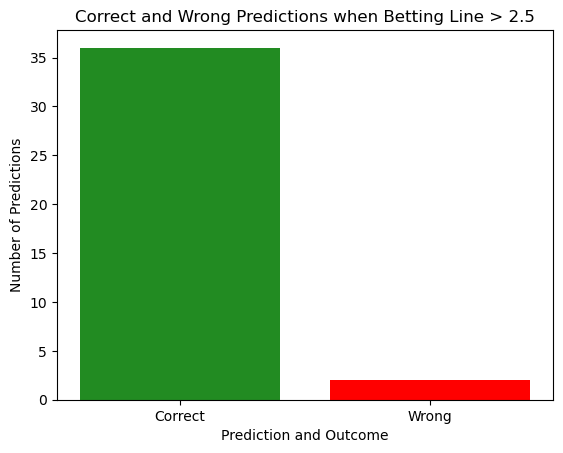

In [52]:
higher_than_correct = 0
higher_than_wrong = 0

for index, row in bet_df.iterrows():
    if row['predicted_outcome'] == row['actual_outcome']:
        if row['predicted_outcome'] == 1:
            if row['B365W'] > 2.5:
                higher_than_correct += 1
        else:
            if row['B365L'] > 2.5:
                higher_than_correct += 1
    else:
        if row['predicted_outcome'] == 1:
            if row['B365W'] > 2.5:
                higher_than_wrong += 1
        else:
            if row['B365L'] > 2.5:
                higher_than_wrong += 1


# Plot the graph
categories = ['Correct', 'Wrong']
counts = [higher_than_correct, higher_than_wrong]

plt.bar(categories, counts, color=['forestgreen', 'red'])
plt.xlabel("Prediction and Outcome")
plt.ylabel("Number of Predictions")
plt.title("Correct and Wrong Predictions when Betting Line > 2.5")
plt.show()

### Calculate the amount we would have after each match betting with different strategies

#### Strategy 1: Always bet half of the total money we have

In [53]:
bet_df['betting_strategy_1'] = 0.0  # To store the money for strategy 1

pd.set_option('display.float_format', '{:.3f}'.format)

# Convert the column to float and round to 3 decimals
bet_df['betting_strategy_1'] = bet_df['betting_strategy_1'].astype(float).round(3)

# Initial amount
initial_amount = 50
money_strategy_1 = initial_amount

# Betting strategy 1
for index, row in bet_df.iterrows():
    bet_amount = money_strategy_1 / 2  # Bet half of the current money
    if row['predicted_outcome'] == row['actual_outcome']:
        if row['predicted_outcome'] == 1:
            money_won = bet_amount * (row['B365W'] - 1)
        else:
            money_won = bet_amount * (row['B365L'] - 1)
        money_strategy_1 += money_won
    else:
        money_won = 0
        money_strategy_1 -= bet_amount
    bet_df.at[index, 'betting_strategy_1'] = money_strategy_1

#### Strategy 2: Bet the total money * prediction probability

In [54]:
bet_df['betting_strategy_2'] = 0.0  # To store the money for strategy 2

# Reset initial amount for strategy 2
initial_amount = 50
money_strategy_2 = initial_amount
    
# Betting strategy 2
for index, row in bet_df.iterrows():
    bet_amount = money_strategy_2 * row['predicted_probability']
    
    if row['predicted_outcome'] == row['actual_outcome']:
        if row['predicted_outcome'] == 1: 
            money_won = bet_amount * (row['B365W'] - 1)
        else:
            money_won = bet_amount * (row['B365L'] - 1)
        money_strategy_2 += money_won
    else: 
        money_won = 0
        money_strategy_2 -= bet_amount
    
    bet_df.at[index, 'betting_strategy_2'] = money_strategy_2


#### Strategy 3: Bet half the money we have, but just on the matches where the predicted probability is >= 60%

In [55]:
# Adding a new column for the third betting strategy
bet_df['betting_strategy_3'] = 0.0  # To store the money for strategy 3

# Convert the columns to float and round to 3 decimals
bet_df['betting_strategy_3'] = bet_df['betting_strategy_3'].astype(float).round(3)

# Reset initial amount for strategy 3
money_strategy_3 = initial_amount

# Betting strategy 3
for index, row in bet_df.iterrows():
    if row['predicted_probability'] >= 0.6:
        bet_amount = money_strategy_3 / 2  # Bet half of the current money
        if row['predicted_outcome'] == row['actual_outcome']:
            money_won = bet_amount * (row['B365W'] - 1) if row['predicted_outcome'] == 1 else bet_amount * (row['B365L'] - 1)
            money_strategy_3 += money_won
        else:
            money_won = 0
            money_strategy_3 -= bet_amount
        bet_df.at[index, 'betting_strategy_3'] = money_strategy_3
    else:
        bet_df.at[index, 'betting_strategy_3'] = money_strategy_3

In [56]:
bet_df

,tourney_name,tourney_year,tourney_month,tourney_day,player1_id,player1_name,player2_name,player2_id,B365W,B365L,predicted_probability,predicted_outcome,actual_outcome,betting_strategy_1,betting_strategy_2,betting_strategy_3
0,3,2024,1,1,126128,Safiullin R.,Shelton B.,210097,2.300,1.620,0.989,1,1,82.500,114.268,82.500
1,908,2024,1,1,111513,Djere,Shang,209992,1.620,2.300,0.063,0,0,136.125,123.592,82.500
2,3,2024,1,1,126845,Purcell M.,Rune H.,208029,4.000,1.250,0.178,0,0,153.141,129.100,82.500
3,908,2024,1,1,132686,Nuno Borges,Kotov,200303,1.800,2.000,0.195,0,0,229.711,154.321,82.500
4,3,2024,1,1,105777,Dimitrov G.,Andy Murray,104918,1.330,3.400,0.729,1,1,267.613,191.453,96.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,924,2024,2,7,105138,Bautista Agut,Khachanov,111575,2.750,1.440,0.872,1,1,4824012921372049775754022435684352.000,114571974024012691859732168704.000,60874636958243840.000
291,34,2024,2,7,105948,Federico Coria,Ramos-Vinolas,105077,1.670,2.200,0.140,0,0,7718420674195280563543639582572544.000,133778682491933734390074441728.000,60874636958243840.000
292,34,2024,2,7,105487,Facundo Bagnis,Roberto Carballes Baena,106148,2.300,1.620,0.812,1,1,12735394112422212238094102547136512.000,274978857976495803509180989440.000,100443150981102336.000
293,34,2024,2,7,202103,Cerundolo F.,Jaume Munar,144719,1.800,2.000,0.918,1,1,17829551757391096210994539880513536.000,476991723057688363592744697856.000,140620411373543264.000


#### Visualize the 3 different strategies

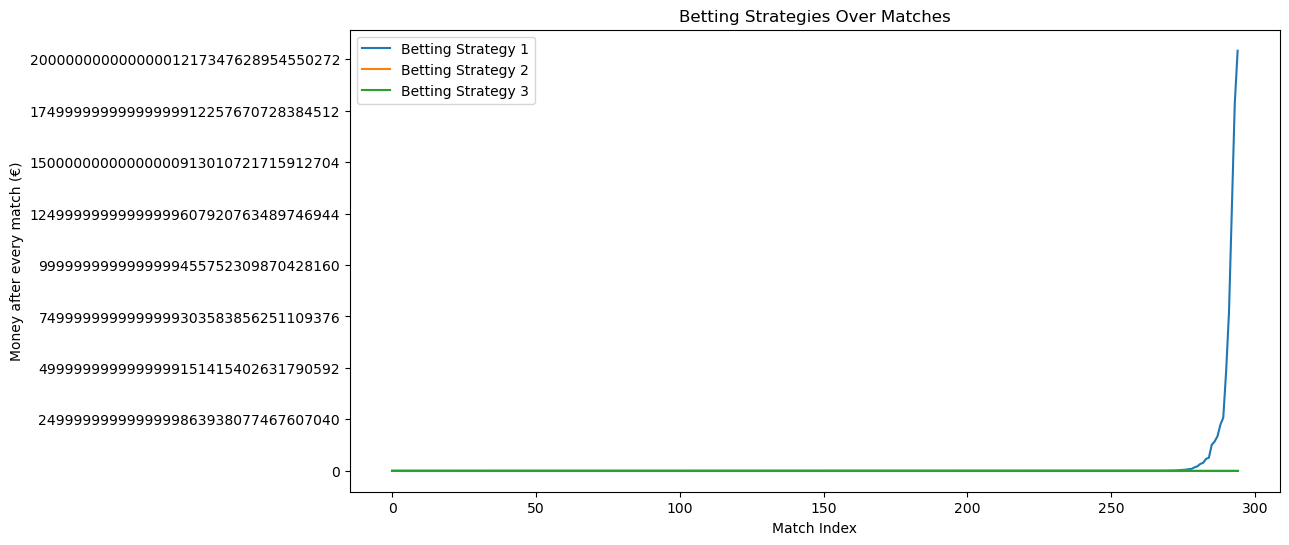

In [57]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(bet_df['betting_strategy_1'], label='Betting Strategy 1')
plt.plot(bet_df['betting_strategy_2'], label='Betting Strategy 2')
plt.plot(bet_df['betting_strategy_3'], label='Betting Strategy 3')
plt.xlabel('Match Index')
plt.ylabel('Money after every match (€)')
plt.title('Betting Strategies Over Matches')
plt.legend()
plt.ticklabel_format(axis='y', style='plain')

plt.show()

## Prediction for matches that have not been played yet

#### Predict results for matches on 2024-02-07

In [58]:
# Test on matches still to be played
X_train = X[~((X['tourney_year'] == 2024) & (X['tourney_month'] == 2) & (X['tourney_day'] == 7))]
X_test = X[(X['tourney_year'] == 2024) & (X['tourney_month'] == 2) & (X['tourney_day'] == 7)]
y_train = y[~((X['tourney_year'] == 2024) & (X['tourney_month'] == 2) & (X['tourney_day'] == 7))]
y_test = y[X_test.index]

# Train the Gradient Boosting model
model  = GradientBoostingClassifier(
    learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6)

model.fit(X_train, y_train)

# Make predictions and get probabilities
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  

In [59]:
# Add predictions and probabilities to the test data
X_test['predicted_outcome'] = predictions
X_test['predicted_probability'] = probabilities

# Display matches with real and predicted outcomes, and probabilities
result_df = X_test[['tourney_name', 'tourney_year', 'tourney_month', 'tourney_day', 'player1_id', 'player2_id', 'predicted_outcome', 'predicted_probability']]
result_df['actual_outcome'] = y_test.values

In [60]:
col1 = ['player1_id', 'player1_name', 'player2_name', 'player2_id', 'B365W', 'B365L', 'tourney_year', 'tourney_month', 'tourney_day']
col2 = ['player2_id', 'player2_name', 'player1_name', 'player1_id', 'B365L', 'B365W', 'tourney_year', 'tourney_month', 'tourney_day']
tmp = pd.concat([betting_lines_24.set_axis(col1, axis=1), betting_lines_24.set_axis(col2, axis=1)])
col3 = ['tourney_name', 'tourney_year', 'tourney_month', 'tourney_day', 'player1_id', 'player1_name', 
        'player2_name', 'player2_id', 'B365W', 'B365L', 'predicted_probability', 'predicted_outcome']
bet_df = result_df.merge(tmp, how='left')[col3]

In [61]:
bet_df

,tourney_name,tourney_year,tourney_month,tourney_day,player1_id,player1_name,player2_name,player2_id,B365W,B365L,predicted_probability,predicted_outcome
0,924,2024,2,7,200000,Auger-Aliassime,Quentin Halys,111460,1.250,4.000,0.976,1
1,924,2024,2,7,209414,Van Assche L.,Emil Ruusuvuori,200325,3.200,1.360,0.083,0
2,924,2024,2,7,207518,Lorenzo Musetti,Tomas Machac,207830,2.200,1.670,0.217,0
3,924,2024,2,7,200005,Humbert U.,Hugo Gaston,200384,1.300,3.500,0.979,1
4,924,2024,2,7,105138,Bautista Agut,Khachanov,111575,2.750,1.440,0.884,1
5,34,2024,2,7,105948,Federico Coria,Ramos-Vinolas,105077,1.670,2.200,0.144,0
6,34,2024,2,7,105487,Facundo Bagnis,Roberto Carballes Baena,106148,2.300,1.620,0.821,1
7,34,2024,2,7,202103,Cerundolo F.,Jaume Munar,144719,1.800,2.000,0.907,1
8,34,2024,2,7,126523,Zapata Miralles,Etcheverry T.,144869,3.750,1.290,0.056,0
